# 랭그래프로 간단한 챗봇 만들기

## 필요 라이브러리 설치

In [1]:
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.


## GPT 모델 설정

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke('안녕하세요!')

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_eca0ce8298', 'id': 'chatcmpl-CiANPP9OLFkg2eBNDbZrJmcGwkJBQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--8c7c2f7b-d4e6-445c-a7d6-e362a30e917d-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## 상태 정의
- `Annotated[T, func]`: 타입 T에 메타데이터나 동작을 추가할 때 사용
- `add_messages`: LangGraph가 제공하는 Reducer로 기존 메시지 리스트를 덮어쓰지않고 새로운 메시지를 리스트 뒤에 추가
  - `Reducer`? 함수형 프로그래밍에서 온 개념으로 기존 값과 새 값을 어떻게 합칠 것인가를 정의하는 함수

In [3]:
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
       'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]



## 그래프 정의
- StateGraph를 생성할 때 상태의 스키마로 State 전달
- 그래프가 처리할 데이터의 형태를 정의

In [4]:
graph_builder = StateGraph(State)

## 챗봇 노드 함수 정의

In [5]:
def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.
		
    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리. 
          형식은 {"messages": [응답 메시지]}입니다.
    """ 
    return {"messages": [model.invoke(state["messages"])]}


graph_builder.add_node("generate", generate) # 그래프에 노드 추가

## 엣지 정의 및 컴파일

In [6]:
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)    

graph = graph_builder.compile()

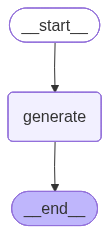

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception: 
    pass

## 그래프 실행
- 응답 메시지 : {'messages': [HumanMessage(...), AIMessage(...)]}

In [9]:
response = graph.invoke({"messages": ["안녕하세요! 저는 김도현입니다"]})

print(type(response))
response

<class 'dict'>


{'messages': [HumanMessage(content='안녕하세요! 저는 김도현입니다', additional_kwargs={}, response_metadata={}, id='a0d4ec87-94dd-4ce2-abca-1f3d1e72c989'),
  AIMessage(content='안녕하세요, 김도현님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 15, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_eca0ce8298', 'id': 'chatcmpl-CiANp07xtKzkCRD3Sn57bR2Zh0g9q', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--c8a53d30-6d86-416e-bb3c-2610c70e036c-0', usage_metadata={'input_tokens': 15, 'output_tokens': 15, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [10]:
response["messages"].append("제 이름을 아시나요?")
graph.invoke(response)

{'messages': [HumanMessage(content='안녕하세요! 저는 김도현입니다', additional_kwargs={}, response_metadata={}, id='a0d4ec87-94dd-4ce2-abca-1f3d1e72c989'),
  AIMessage(content='안녕하세요, 김도현님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 15, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_eca0ce8298', 'id': 'chatcmpl-CiANp07xtKzkCRD3Sn57bR2Zh0g9q', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--c8a53d30-6d86-416e-bb3c-2610c70e036c-0', usage_metadata={'input_tokens': 15, 'output_tokens': 15, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),

## 스트리밍 출력

In [11]:
inputs = {"messages": [("human", "한국과 일본의 관계에 대해 자세히 알려줘")]}
for chunk, _ in graph.stream(inputs, stream_mode="messages"):
    print(chunk.content, end="")

한국과 일본의 관계는 역사적으로 복잡하고 다면적입니다. 이 두 나라는 지리적으로 가까운 이웃국가이지만, 역사적, 문화적, 정치적 요인으로 인해 갈등과 협력이 동시에 존재해왔습니다.

### 1. 역사적 배경

- **일제 강점기 (1910-1945)**: 한국은 1910년부터 1945년까지 일본의 식민지로 지배받았습니다. 이 시기 한국의 문화와 언어, 전통이 억압당하고 많은 한국인들이 강제 노동과 위안부로 희생당했습니다. 이 역사적 경험은 현재까지도 두 나라 간의 감정적 갈등의 주요 원인 중 하나입니다.

- **제2차 세계대전 이후**: 일본이 패망한 후 한국은 1945년에 해방되었고, 이후 1948년에 대한민국과 1949년에 조선민주주의인민공화국이 각각 수립되었습니다. 이후 한반도는 남북으로 나뉘게 되었고, 이로 인해 일본과 한국 사이의 관계도 복잡하게 얽히게 되었습니다.

### 2. 경제 관계

- **무역**: 한국과 일본은 서로 중요한 무역 파트너국입니다. 일본은 한국의 주요 수출 시장 중 하나이며, 한국도 일본의 중요한 수출 시장입니다. 양국 간의 경제적 연관성은 깊지만, 정치적 갈등이 경제 교류에 영향을 미치기도 합니다.

- **기술 협력**: 일본은 한국의 기술 발전에 기여해왔으며, 한국은 일본에 대한 반도체 및 전자 제품의 주요 공급국 역할을 해왔습니다. 최근에는 디지털 경제와 신기술 영역에서도 협력이 확대되고 있습니다.

### 3. 정치적 관계

- **영토 문제**: 독도(일본명: 다케시마)라는 영토 분쟁이 두 나라 간의 갈등을 심화시키고 있습니다. 이 지역은 양국에서 각각 자국의 영토라고 주장하고 있어, 정치적 긴장의 원인이 됩니다.

- **역사 인식**: 일본의 역사 교과서 문제나 일본 정부의 최근 발언들은 한국에서 불만을 초래하며, 양국 간의 긴장을 더욱 고조시키는 요인으로 작용하고 있습니다.

### 4. 문화적 교류

- **한류와 J-Pop**: 최근 몇 년간 한국의 음악, 영화, 드라마(한류)는 일본에서도 큰 인기를 얻고